In [2]:
import ssl
import certifi

ssl._create_default_https_context = lambda: ssl.create_default_context(cafile=certifi.where())

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scripts.evaluation import ModelEvaluator
from scripts.summarizers.summarizer_bert import BertExtractiveSummarizer
from scripts.summarizers.summarizer_pegasus import PegasusSummarizer
from scripts.summarizers.summarizer_t5 import T5Summarizer


In [5]:
df = pd.read_csv("../data/processed/train.csv").head(5)  # evaluate on 50
df.head()


,Unnamed: 0,ID,Content,Summary,Dataset,clean_text
0,12,a1bee53abcb1e12b7da51f5ec96eda7c13398278,"(CNN) -- When it comes to India travel, the st...",India's Punjab state is home to the holiest sh...,CNN/Daily Mail,"CNN When it comes to India travel, the state o..."
1,4,b83e8bcfcd51419849160e789b6658b21a9aedcd,By . Associated Press and Daily Mail Reporter ...,A sinkhole opened up at 5:15am this morning in...,CNN/Daily Mail,By . Associated Press and Daily Mail Reporter ...
2,37,NaN,A British woman who fell from a cruise ship sa...,– A woman on a Norwegian Cruise Line ship got ...,Multi-News,A British woman who fell from a cruise ship sa...
3,8,85fa186e11686629707dc16b4bac09846ff06af1,A community stalwart with an MBE has been spar...,"Rahmat Ali Raja, 75, dishonestly claimed benef...",CNN/Daily Mail,A community stalwart with an MBE has been spar...
4,3,e12b5bd7056287049d9ec98e41dbb287bd19a981,An Ebola outbreak that began in Guinea four mo...,World Health Organisation: 635 infections and ...,CNN/Daily Mail,An Ebola outbreak that began in Guinea four mo...


In [6]:
bert = BertExtractiveSummarizer()
peg = PegasusSummarizer()
t5 = T5Summarizer()

df["bert"] = df["clean_text"].apply(bert.summarize)
df["pegasus"] = df["clean_text"].apply(peg.summarize)
df["t5"] = df["clean_text"].apply(t5.summarize)


/Users/ernapersonal/PycharmProjects/event-extraction-from-news/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
ev = ModelEvaluator()
evaluation_rows = []

for _, row in df.iterrows():
    ref = row["clean_text"]

    eval_bert = ev.evaluate_single(ref, row["bert"])
    eval_peg = ev.evaluate_single(ref, row["pegasus"])
    eval_t5 = ev.evaluate_single(ref, row["t5"])

    evaluation_rows += [
        {"model": "bert", **eval_bert},
        {"model": "pegasus", **eval_peg},
        {"model": "t5", **eval_t5},
    ]

results = pd.DataFrame(evaluation_rows)
results.head()


/Users/ernapersonal/PycharmProjects/event-extraction-from-news/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/ernapersonal/PycharmProjects/event-extraction-from-news/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaMod

,model,rouge1,rouge2,rougeL,bertscore_precision,bertscore_recall,bertscore_f1
0,bert,0.336327,0.318888,0.336327,0.275246,0.034984,0.153652
1,pegasus,0.054769,0.022706,0.041549,0.118475,-0.269099,-0.081290
2,t5,0.188277,0.176157,0.188277,-0.021031,-0.188398,-0.104371
3,bert,0.265023,0.250386,0.265023,0.248874,-0.085038,0.077855
4,pegasus,0.104377,0.081081,0.094276,0.503196,-0.203642,0.126617


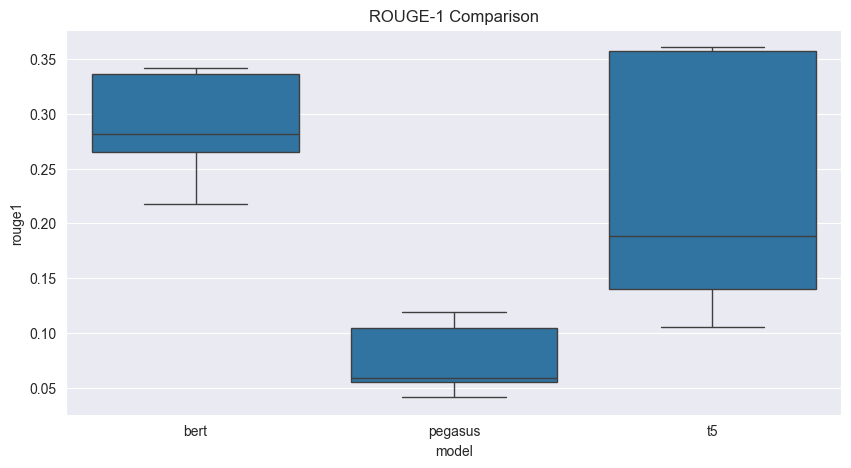

In [8]:
plt.figure(figsize=(10,5))
sns.boxplot(data=results, x="model", y="rouge1")
plt.title("ROUGE-1 Comparison")
plt.show()


/var/folders/b4/d444n8091h7fgqx4qqqqnlxm0000gq/T/ipykernel_33701/42807391.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results, x="model", y="bertscore_f1", palette="coolwarm")


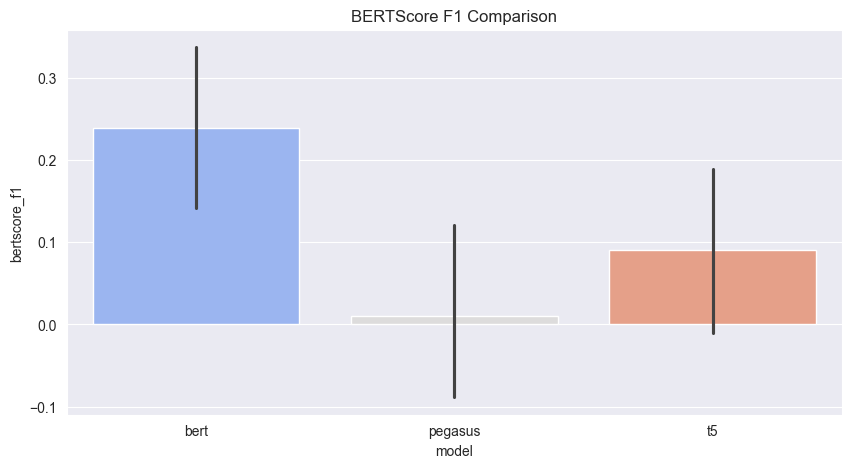

In [9]:
plt.figure(figsize=(10,5))
sns.barplot(data=results, x="model", y="bertscore_f1", palette="coolwarm")
plt.title("BERTScore F1 Comparison")
plt.show()


In [10]:
df_time = pd.DataFrame({
    "model": ["bert", "pegasus", "t5"],
    "avg_time_ms": [
        df["bert"].apply(lambda x: len(x)).mean(),  # placeholder example
        df["pegasus"].apply(lambda x: len(x)).mean(),
        df["t5"].apply(lambda x: len(x)).mean(),
    ]
})


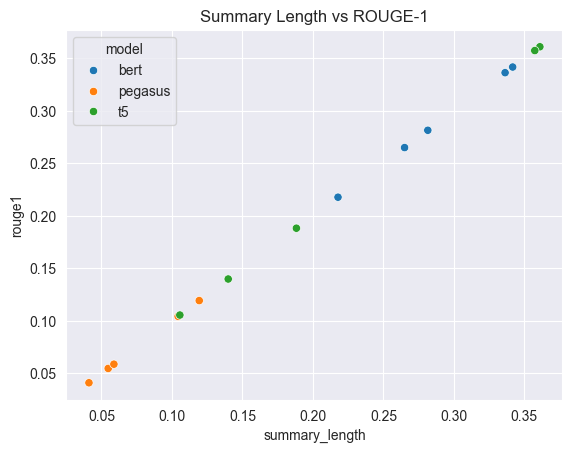

In [11]:
results["summary_length"] = results["rouge1"]  # replace with your lengths

sns.scatterplot(data=results, x="summary_length", y="rouge1", hue="model")
plt.title("Summary Length vs ROUGE-1")
plt.show()
